In [2]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from alibi_detect.cd import KSDrift

In [3]:
TRAINING_DATA = '../data/processed/datasets_processed/training_data/'
RATIO = .2
ko = '.DS_Store'

In [4]:
def orig_data():

	train_i = os.listdir(TRAINING_DATA)
	if ko in train_i: train_i.remove(ko)
	limit = int(len(train_i) * RATIO)
	random.seed(42)

	samples = [cv2.imread(TRAINING_DATA + i, cv2.IMREAD_COLOR) for i in random.sample(train_i, limit)]
	grays = [cv2.cvtColor(i, cv2.COLOR_BGR2GRAY).flatten() for i in samples]
	hists = [np.histogram(i, 256, [0, 256])[0] for i in grays]
	cumsums = [h.cumsum() * float(h.max()) / h.cumsum().max() for h in hists]

	return samples, grays, hists, cumsums

In [5]:
def fake_data(data, distortion):

    alpha = .6 if distortion == 'low' else 2 # Alpha controls contrast
    beta = 3 if distortion == 'low' else 8   # Beta controls brightness

    fake = {}
    fake['imgs'] = [cv2.convertScaleAbs(img, alpha=alpha, beta=beta) for img in data]
    fake['grays'] = [cv2.cvtColor(i, cv2.COLOR_BGR2GRAY).flatten() for i in fake['imgs']]
    fake['hists'] = [np.histogram(i, 256, [0, 256])[0] for i in fake['grays']]
    fake['cumsums'] = [h.cumsum() * float(h.max()) / h.cumsum().max() for h in fake['hists']]

    return fake

In [6]:
samples, grays, hists, cumsums = orig_data()
fake_low = fake_data(samples, distortion='low')
fake_high = fake_data(samples, distortion='high')

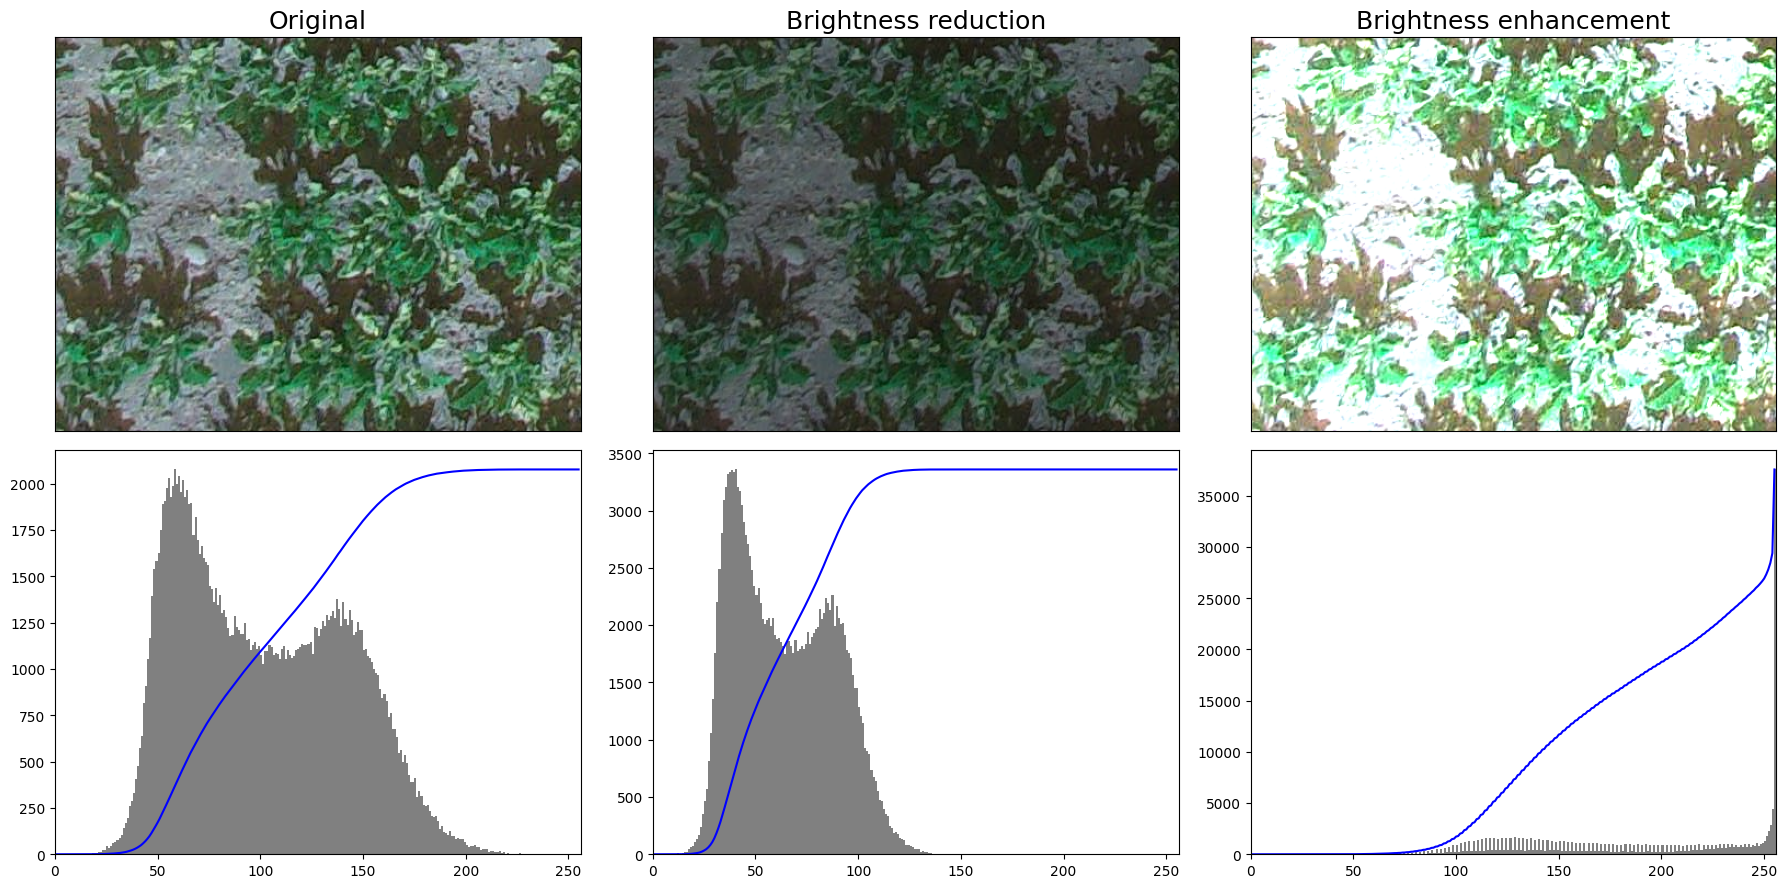

In [15]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 9))
sample_idx = random.sample([i for i in range(len(samples))], 1)[0]
l = fake_data([samples[sample_idx]], distortion='low')
h = fake_data([samples[sample_idx]], distortion='high')
ax1.imshow(samples[sample_idx])
ax1.set_title('Original', fontsize=18)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(l['imgs'][0])
ax2.set_title('Brightness reduction', fontsize=18)
ax2.set_xticks([])
ax2.set_yticks([])
ax3.imshow(h['imgs'][0])
ax3.set_title('Brightness enhancement', fontsize=18)
ax3.set_xticks([])
ax3.set_yticks([])

ax4.plot(cumsums[sample_idx], color = 'blue')
ax4.hist(cv2.cvtColor(samples[sample_idx], cv2.COLOR_BGR2GRAY).flatten(), 256, [0, 256], color='gray')
ax4.set_xlim([0, 256])

ax5.plot(l['cumsums'][0], color = 'blue')
ax5.hist(l['grays'][0], 256, [0, 256], color='gray')
ax5.set_xlim([0, 256])

ax6.plot(h['cumsums'][0], color = 'blue')
ax6.hist(h['grays'][0], 256, [0, 256], color='gray')
ax6.set_xlim([0, 256])

fig.tight_layout()
plt.show()

In [16]:
gray_avg = [i / len(grays) for i in list(map(sum, zip(*grays)))]
hist_avg = [i / len(hists) for i in list(map(sum, zip(*hists)))]
cumsum_avg = [i / len(cumsums) for i in list(map(sum, zip(*cumsums)))]

low_gray_avg = [i / len(fake_low['grays']) for i in list(map(sum, zip(*fake_low['grays'])))]
low_hist_avg = [i / len(fake_low['hists']) for i in list(map(sum, zip(*fake_low['hists'])))]
low_cumsum_avg = [i / len(fake_low['cumsums']) for i in list(map(sum, zip(*fake_low['cumsums'])))]

high_gray_avg = [i / len(fake_high['grays']) for i in list(map(sum, zip(*fake_high['grays'])))]
high_hist_avg = [i / len(fake_high['hists']) for i in list(map(sum, zip(*fake_high['hists'])))]
high_cumsum_avg = [i / len(fake_high['cumsums']) for i in list(map(sum, zip(*fake_high['cumsums'])))]

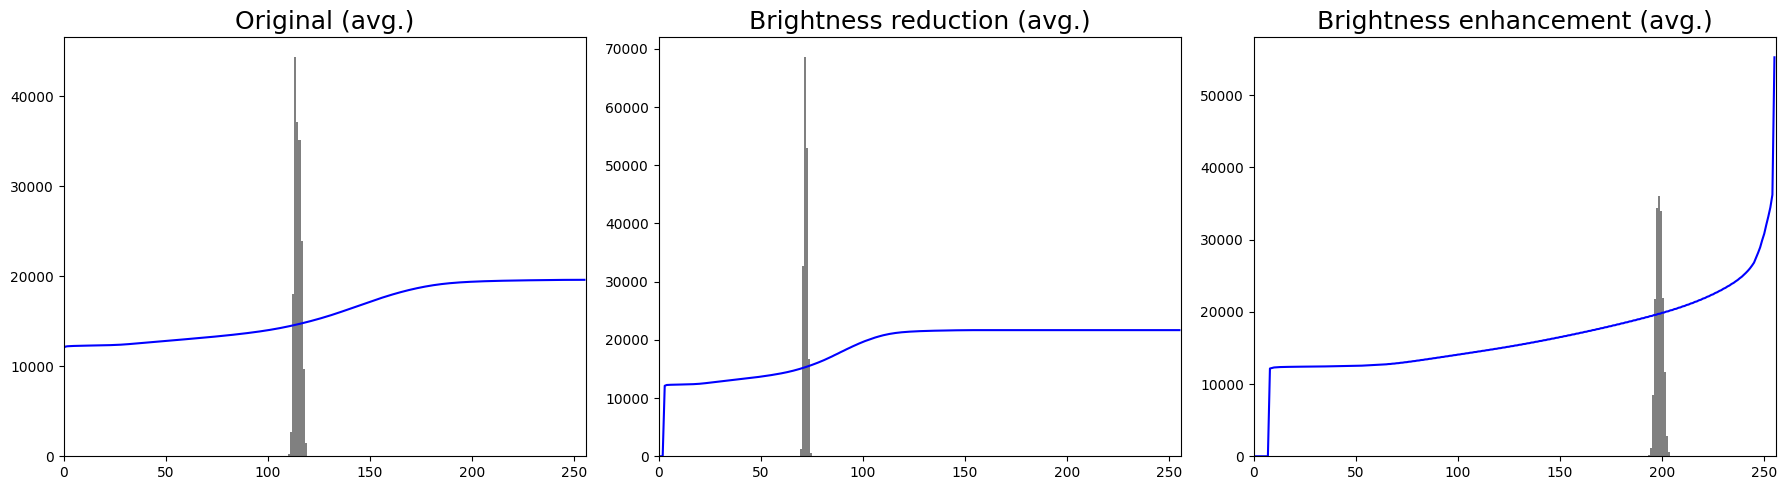

In [17]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 5))

ax1.plot(cumsum_avg, color = 'blue')
ax1.hist(gray_avg, 256, [0, 256], color='gray')
ax1.set_xlim([0, 256])
ax1.set_title('Original (avg.)', fontsize=18)

ax2.plot(low_cumsum_avg, color = 'blue')
ax2.hist(low_gray_avg, 256, [0, 256], color='gray')
ax2.set_xlim([0, 256])
ax2.set_title('Brightness reduction (avg.)', fontsize=18)

ax3.plot(high_cumsum_avg, color = 'blue')
ax3.hist(high_gray_avg, 256, [0, 256], color='gray')
ax3.set_xlim([0, 256])
ax3.set_title('Brightness enhancement (avg.)', fontsize=18)

fig.tight_layout()
plt.show()

In [34]:
data_drift_detector = KSDrift(np.array(hist_avg), p_val=0.01)
preds_low = data_drift_detector.predict(np.array(low_hist_avg), drift_type='batch', return_p_val=True, return_distance=True)
preds_high = data_drift_detector.predict(np.array(high_hist_avg), drift_type='batch', return_p_val=True, return_distance=True)

In [35]:
print(''.join(['> ' for i in range(30)]))
print(f'\n{"PROP":<20}{"LOW IMAGES":>15}{"HIGH IMAGES":>20}\n')
print(''.join(['> ' for i in range(30)]))
print(f'\n{"NAME":<20}{preds_low["meta"]["name"]:>15}{preds_high["meta"]["name"]:>20}')
for _, v in enumerate(preds_low["data"].keys()):
	print(f'\n{v.upper():<20}{str(preds_low["data"][v]):>15}{str(preds_high["data"][v]):>20}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

PROP                     LOW IMAGES         HIGH IMAGES

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

NAME                        KSDrift             KSDrift

IS_DRIFT                          1                   1

DISTANCE                [0.3984375]         [0.3828125]

P_VAL               [7.6135265e-19]     [2.2198778e-17]

THRESHOLD                      0.01                0.01
